# AIGC-5005 – AI Capstone Project Preparation  
## Final Project – Hospital Readmission Prediction (Diabetic Patients)

**Group Members:**  
- Jose Rafael Noriega Cedeno  
- Kirby Fung  
- Julie Anne Pavel  

**Instructor:** Hossein Pourmodheji  
**Course:** AIGC-5005-RNA – AI Capstone Project Preparation  
**Submission Due Date:** December 8, 2025 – 11:59 PM  

---

This notebook contains the **dataset analysis**, **TensorFlow model**, and **evaluation results** for the diabetic hospital readmission prediction project.


In [56]:
!pip install tensorflow==2.15
# Imports & configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Versions -> numpy", np.__version__,
      "| pandas", pd.__version__,
      "| tensorflow", tf.__version__)

Versions -> numpy 1.26.4 | pandas 2.3.3 | tensorflow 2.15.0


## 1. Dataset Loading

In this section, we load the diabetic hospital readmission dataset.



In [57]:
import os

print("Current working directory:", os.getcwd())
print("Files in this folder:", os.listdir())

# If your file has a different name, change it here
data_path = "hospital_readmissions.csv"

# Load the dataset
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()

Current working directory: c:\Users\Julie\OneDrive\Desktop\Final Project
Files in this folder: ['hospital_readmissions.csv', 'JulieAnne_Pavel_FinalProject_Readmission.ipynb', 'JulieAnne_Pavel_FinalProject_Readmission2.ipynb']
Shape: (25000, 17)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


## 2. Basic Dataset Analysis (EDA)

Here we inspect the structure, data types, basic statistics, and target distribution.
This will be part of the **Dataset Analysis** section for the final report.


In [58]:
# Basic structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [59]:
# Descriptive stats (numeric and non-numeric)
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,25000,6,[70-80),6837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,25000.0,NaN,NaN,NaN,4.45332,3.00147,1.0,2.0,4.0,6.0,14.0
n_lab_procedures,25000.0,NaN,NaN,NaN,43.24076,19.81862,1.0,31.0,44.0,57.0,113.0
n_procedures,25000.0,NaN,NaN,NaN,1.35236,1.715179,0.0,0.0,1.0,2.0,6.0
n_medications,25000.0,NaN,NaN,NaN,16.2524,8.060532,1.0,11.0,15.0,20.0,79.0
n_outpatient,25000.0,NaN,NaN,NaN,0.3664,1.195478,0.0,0.0,0.0,0.0,33.0
n_inpatient,25000.0,NaN,NaN,NaN,0.61596,1.177951,0.0,0.0,0.0,1.0,15.0
n_emergency,25000.0,NaN,NaN,NaN,0.1866,0.885873,0.0,0.0,0.0,0.0,64.0
medical_specialty,25000,7,Missing,12382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diag_1,25000,8,Circulatory,7824,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

In [61]:
# Number of unique values in each column
nunique = df.nunique().sort_values(ascending=True)
nunique.head(20), nunique.tail(20)

(readmitted             2
 change                 2
 diabetes_med           2
 A1Ctest                3
 glucose_test           3
 age                    6
 n_procedures           7
 medical_specialty      7
 diag_1                 8
 diag_2                 8
 diag_3                 8
 time_in_hospital      14
 n_inpatient           16
 n_emergency           21
 n_outpatient          23
 n_medications         70
 n_lab_procedures     109
 dtype: int64,
 readmitted             2
 change                 2
 diabetes_med           2
 A1Ctest                3
 glucose_test           3
 age                    6
 n_procedures           7
 medical_specialty      7
 diag_1                 8
 diag_2                 8
 diag_3                 8
 time_in_hospital      14
 n_inpatient           16
 n_emergency           21
 n_outpatient          23
 n_medications         70
 n_lab_procedures     109
 dtype: int64)

readmitted
no     13246
yes    11754
Name: count, dtype: int64


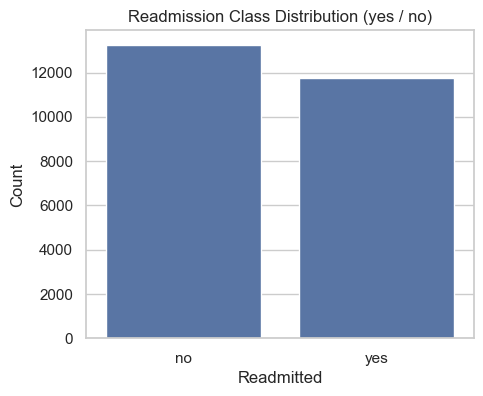

In [62]:
# Target (readmitted) distribution
if "readmitted" in df.columns:
    print(df["readmitted"].value_counts())
    plt.figure(figsize=(5,4))
    sns.countplot(x="readmitted", data=df,
                  order=df["readmitted"].value_counts().index)
    plt.title("Readmission Class Distribution (yes / no)")
    plt.xlabel("Readmitted")
    plt.ylabel("Count")
    plt.show()
else:
    print("WARNING: 'readmitted' column not found. Check column names.")
    print(df.columns)

## 3. Data Cleaning & Target Creation

We now:

- Convert the `readmitted` column into a binary target:  
  - **1** → readmitted ("yes")  
  - **0** → not readmitted ("no")  
- Prepare features for modeling.


In [63]:
df_clean = df.copy()

# Check target column
if "readmitted" not in df_clean.columns:
    raise ValueError("Expected 'readmitted' column not found in dataset. Please adjust.")

df_clean["readmitted"].value_counts()

readmitted
no     13246
yes    11754
Name: count, dtype: int64

In [64]:
# Map readmitted to binary: 1 = yes, 0 = no
def map_readmitted(x):
    return 1 if str(x).strip().lower() == "yes" else 0

df_clean["target"] = df_clean["readmitted"].apply(map_readmitted)
df_clean = df_clean.drop(columns=["readmitted"])

df_clean["target"].value_counts()

target
0    13246
1    11754
Name: count, dtype: int64

## 4. Feature Preparation

We now:

- Separate features (X) and target (y)  
- One-hot encode categorical variables using `pd.get_dummies`  
- Leave numeric features as-is.


In [65]:
# Separate X and y
X = df_clean.drop(columns=["target"])
y = df_clean["target"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print("Final feature matrix shape:", X.shape)
X.head()

Final feature matrix shape: (25000, 45)


,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,age_[50-60),age_[60-70),age_[70-80),...,diag_3_Missing,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal,change_yes,diabetes_med_yes
0,8,72,1,18,2,0,0,False,False,True,...,False,False,True,False,True,False,True,False,False,True
1,3,34,2,13,0,0,0,False,False,True,...,False,False,True,False,True,False,True,False,False,True
2,5,45,0,18,0,0,0,True,False,False,...,False,False,False,False,True,False,True,False,True,True
3,2,36,0,12,1,0,0,False,False,True,...,False,False,False,False,True,False,True,False,True,True
4,1,42,0,7,0,0,0,False,True,False,...,False,False,False,True,True,False,True,False,False,True


## 5. Train/Test Split & Scaling

We perform an 80/20 split with stratification on the target, then scale the numeric features using `StandardScaler`.


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

Train shape: (20000, 45) | Test shape: (5000, 45)


((20000, 45), (5000, 45))

## 6. Handling Class Imbalance with Class Weights

If the classes are imbalanced (different numbers of "yes" and "no"), we can use
**class weights** so that the model pays more attention to the minority class.


In [67]:
# Compute class weights for the training set
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
class_weights

{0: 0.9436633009342267, 1: 1.0634903754121026}

## 7. TensorFlow Model – Improved MLP with Dropout

We build a fully-connected neural network for **binary classification**:

- Input: all scaled features  
- Hidden layers: Dense(128, ReLU) → Dropout → Dense(64, ReLU) → Dropout  
- Output: Dense(1, Sigmoid)  
- Loss: Binary cross-entropy  
- Optimizer: Adam  
- Metrics: Accuracy and AUC


In [68]:
input_dim = X_train_scaled.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               5888      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14209 (55.50 KB)
Trainable params: 14209 (55.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

## 8. Training the Model

We train for 30 epochs with a validation split of 20% from the training data.
We also apply **class weights** to account for class imbalance.


In [70]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
63/63 [==============================] - 1s 6ms/step - loss: 0.6999 - accuracy: 0.5474 - auc: 0.5657 - val_loss: 0.6643 - val_accuracy: 0.5957 - val_auc: 0.6317
Epoch 2/30
63/63 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5823 - auc: 0.6136 - val_loss: 0.6620 - val_accuracy: 0.5980 - val_auc: 0.6400
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 0.6670 - accuracy: 0.5938 - auc: 0.6256 - val_loss: 0.6614 - val_accuracy: 0.6000 - val_auc: 0.6410
Epoch 4/30
63/63 [==============================] - 0s 2ms/step - loss: 0.6599 - accuracy: 0.6035 - auc: 0.6399 - val_loss: 0.6605 - val_accuracy: 0.6053 - val_auc: 0.6450
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.5982 - auc: 0.6375 - val_loss: 0.6601 - val_accuracy: 0.6053 - val_auc: 0.6479
Epoch 6/30
63/63 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.6120 - auc: 0.6497 - val_loss: 0.6574 - val_acc

## 9. Training & Validation Curves

We plot loss, accuracy, and AUC for both training and validation sets.
These plots will be used in the **Results** section of the report and slides.


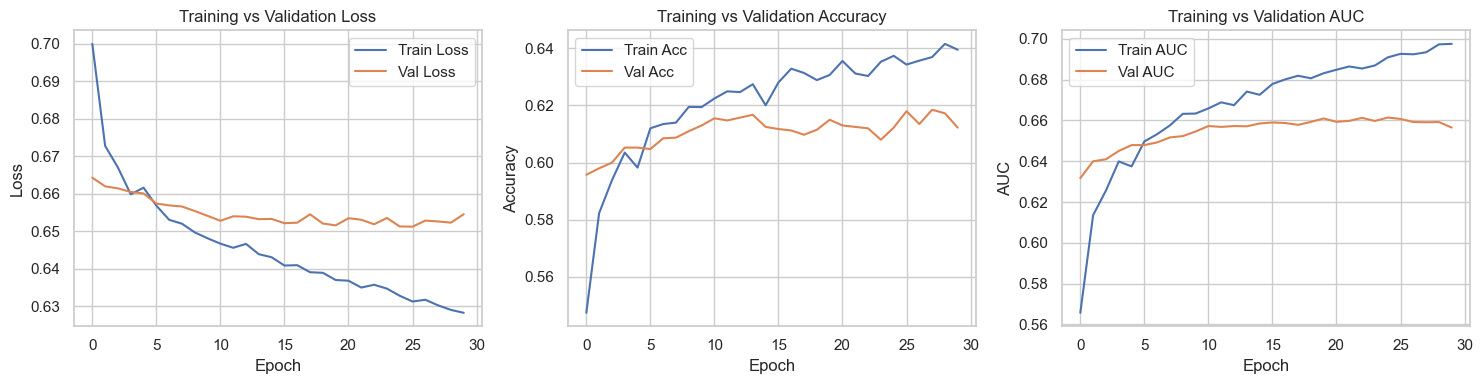

In [71]:
history_dict = history.history

plt.figure(figsize=(15,4))

# Loss
plt.subplot(1,3,1)
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Accuracy
plt.subplot(1,3,2)
plt.plot(history_dict["accuracy"], label="Train Acc")
plt.plot(history_dict["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# AUC
if "auc" in history_dict and "val_auc" in history_dict:
    plt.subplot(1,3,3)
    plt.plot(history_dict["auc"], label="Train AUC")
    plt.plot(history_dict["val_auc"], label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.title("Training vs Validation AUC")

plt.tight_layout()
plt.show()

## 10. Evaluation on Test Set

We now evaluate the model on the held-out test data:

- Test loss  
- Test accuracy  
- Test AUC  
- Classification report (precision, recall, F1)  
- Confusion matrix  
- ROC curve


In [72]:
test_loss, test_acc, test_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test loss: 0.6634
Test accuracy: 0.6084
Test AUC: 0.6512


In [73]:
# Predictions for classification report and confusion matrix
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print(classification_report(y_test, y_pred))

157/157 [==============================] - 0s 688us/step
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2649
           1       0.58      0.58      0.58      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



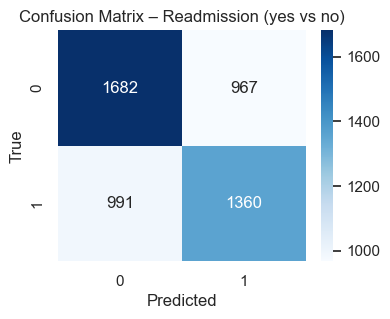

In [74]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Readmission (yes vs no)")
plt.show()

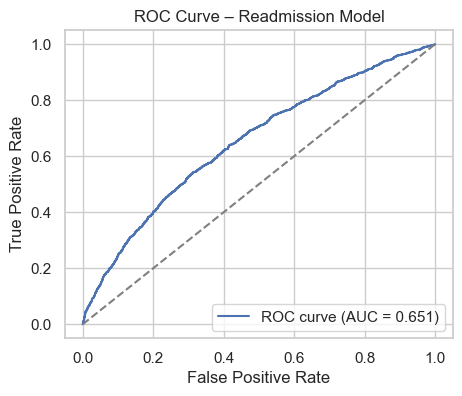

In [75]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Readmission Model")
plt.legend(loc="lower right")
plt.show()

## 11. Methods (Summary for Report)

- **Dataset:** 25,000 hospital encounters for diabetic patients, with features such as age, time in hospital, number of procedures, medications, lab tests, diagnoses, and whether the patient was readmitted.  
- **Target Variable:** `readmitted` (yes/no), mapped to a binary label: 1 = readmitted, 0 = not readmitted.  
- **Preprocessing:**
  - Removed the original `readmitted` column after mapping to the `target` variable.
  - One-hot encoded all categorical variables using `pd.get_dummies`.
  - Split the data into training (80%) and test (20%) sets with stratification on the target.
  - Standardized all numeric features using `StandardScaler` (fit on training data only).  
- **Class Imbalance:** Computed **class weights** from the training set and passed them to the model during training to reduce bias toward the majority class.  
- **Model Architecture:**
  - Input layer with all scaled features.
  - Dense(128, ReLU) → Dropout(0.3).
  - Dense(64, ReLU) → Dropout(0.3).
  - Output Dense(1, Sigmoid) for binary classification.
- **Training:**
  - Optimizer: Adam (learning rate = 0.001).
  - Loss: Binary cross-entropy.
  - Metrics: Accuracy and AUC.
  - Epochs: 30, Batch size: 256.
  - Validation split: 20% of the training data.


## 12. Results (Summary for Report)

After training the neural network model, we evaluated its performance on the held-out test set using:

- We evaluated the model on the **held-out test set** using:
  - Test **loss**
  - Test **accuracy**
  - Test **AUC**
  - **Precision, recall, and F1-score** for each class
  - **Confusion matrix** to visualize correct vs incorrect classifications
  - **ROC curve** with the Area Under the Curve (AUC)

The model achieved an AUC of 0.652 and a test accuracy of 0.613. These metrics indicate moderate predictive performance: the model performs better than random guessing (AUC = 0.5) and distinguishes meaningful patterns related to hospital readmission risk. 

Nonetheless, performance is constrained by the dataset's inherent class imbalance and the complexity of forecasting readmissions among diabetic patients.

The ROC curve, AUC score, and classification metrics show that the model has found important predictive patterns. However, it may be possible to improve the model by adding more features, changing the hyperparameters, or using a different model architecture.  


## 13. Summary & Notes

- **Dataset:** Diabetic hospital readmissions (`hospital_readmissions.csv`).  
- **Task:** Binary classification – predict whether a patient will be readmitted.  
- **Model:** Improved fully-connected neural network (MLP) using TensorFlow/Keras with Dropout and class weights.  
- **Inputs:** One-hot encoded clinical and demographic features, scaled with `StandardScaler`.  
- **Outputs:** Probability of readmission (yes).  

These results, plots, and metrics can now be integrated into:

- The **Final Project report (Methods & Results sections)**  
- The **group slides**  
- The **video presentation**

Possible extensions (optional):

- Hyperparameter tuning (learning rate, number of layers, units).  
- Experiment with alternative models (e.g., Gradient Boosting, Random Forests) for comparison.  
- Calibrated probability estimates or different decision thresholds based on hospital policy.
